# Workflow 2 Inference

Inference is the process of identifying parameter values for a model for a given dataset.  On the HIP platform, inference with a TVB model of a patient's brain allows identifying regions of high epileptogenicity.  In this workflow, we'll make use of methods from the Bayesian Virtual Epileptic Patient work to do this.  Once the results are summarized, we generate an overlay image that can be used in other visualization tools for comparison.

In [1]:
%pip uninstall -y tvb-gdist

Found existing installation: tvb-gdist 2.1.0
Uninstalling tvb-gdist-2.1.0:
  Successfully uninstalled tvb-gdist-2.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pylab inline
%config InlineBackend.figure_format='retina'
import cmdstanpy
from tvb.simulator.lab import *
import numpy as np
import mne

Populating the interactive namespace from numpy and matplotlib
2022-01-27 14:33:26,888 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/apps/tvb-hip/jlab_server/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [6]:
%cd /work

/work


In [7]:
# model = cmdstanpy.CmdStanModel(stan_file='bvep.stan')
model = cmdstanpy.CmdStanModel(exe_file='./bvep_')
# model.compile()

WARNING  File 'hemispheres' not found in ZIP.


(Text(0.5, 0, 'ROI (DK atlas)'), Text(0, 0.5, 'ROI'))

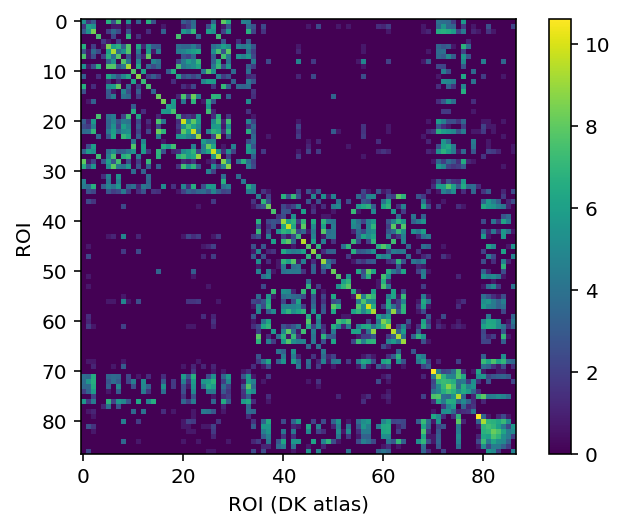

In [8]:
conn = connectivity.Connectivity.from_file('/data/chuv/tvb/connectivity.zip')
conn.weights[:] = np.log(1 + conn.weights)
imshow(conn.weights); colorbar(); xlabel('ROI (DK atlas)'), ylabel('ROI')

Extracting parameters from /data/chuv/seeg/12.vhdr...
Setting channel info structure...
Reading 0 ... 490495  =      0.000 ...  3831.992 secs...


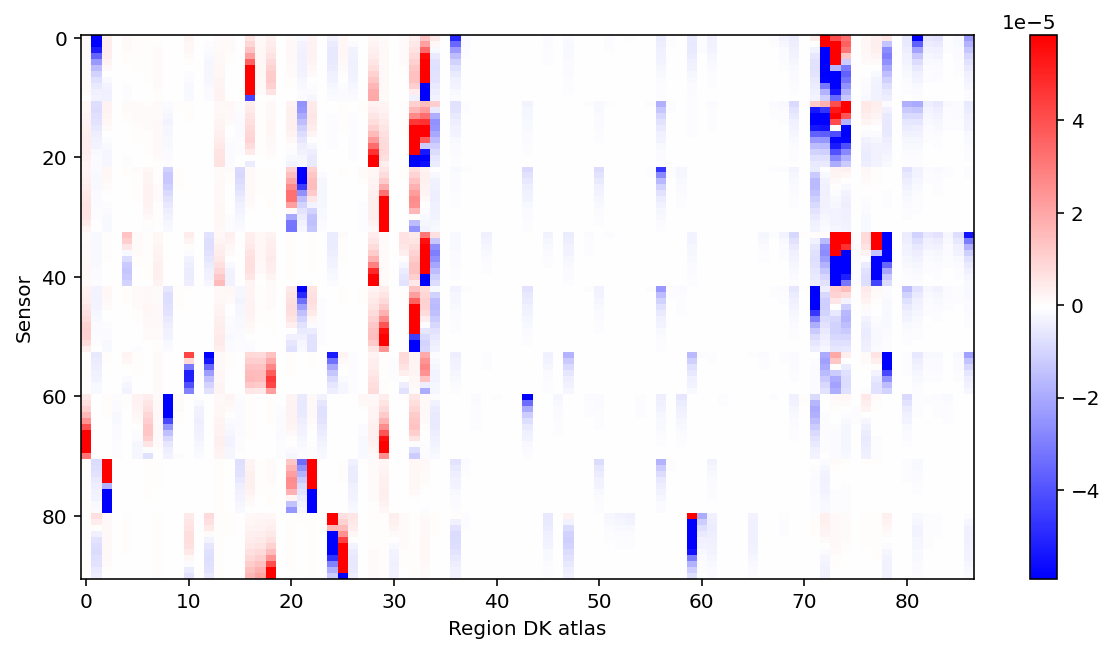

In [9]:
raw = mne.io.read_raw_brainvision('/data/chuv/seeg/12.vhdr',preload=True)
pl_names = []
pl_xyz = []
with open('/data/chuv/pos-t1.txt', 'r') as fd:
    for line in fd.readlines():
        if line.startswith('plot'):
            continue
        name, *xyz = line.strip().split(' ')
        pl_names.append(name)
        pl_xyz.append(np.array([float(_) for _ in xyz]))

def cxyz(pl, idx, contact_dist=3.5):
    target, entry = pl_xyz[pl_names.index(pl)].reshape((2, 3))
    axis = entry - target
    unit = axis / np.linalg.norm(axis)
    return target + contact_dist * (idx - 1) * unit
re_one = '([A-Z][A-Za-z]*\'?) ([0-9]+)'
re_bip = re.compile(f'{re_one}-{re_one}')
ch_bip_idx = []
bip_gain = []
electrodes = []
picks = []
pick_names = []
for i_ch, ch in enumerate(raw.ch_names):
    match = re_bip.match(ch)
    if match:
        picks.append(i_ch)
        pick_names.append(ch)
        e, i, _, j = match.groups()
        electrodes.append(e)
        i, j = int(i), int(j)
        e = e.replace('\'', 'p')
        ch_bip_idx.append((e, i, j))
        r = np.sqrt(np.sum((cxyz(e,np.c_[i,j].T)[:,None] - conn.centres)**2, axis=2))
        g = 1/r**3
        bip_gain.append(g[1] - g[0])
picks = np.array(picks)
bip_gain = np.array(bip_gain)
bip_gain = np.clip(bip_gain, *np.percentile(bip_gain.flat[:], [1,99]))
figure(figsize=(10, 5))
imshow(bip_gain, cmap='bwr', aspect='auto', interpolation='none'), colorbar(), xlabel('Region DK atlas'), ylabel('Sensor');

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 845 samples (6.602 sec)

Using matplotlib as 2D backend.


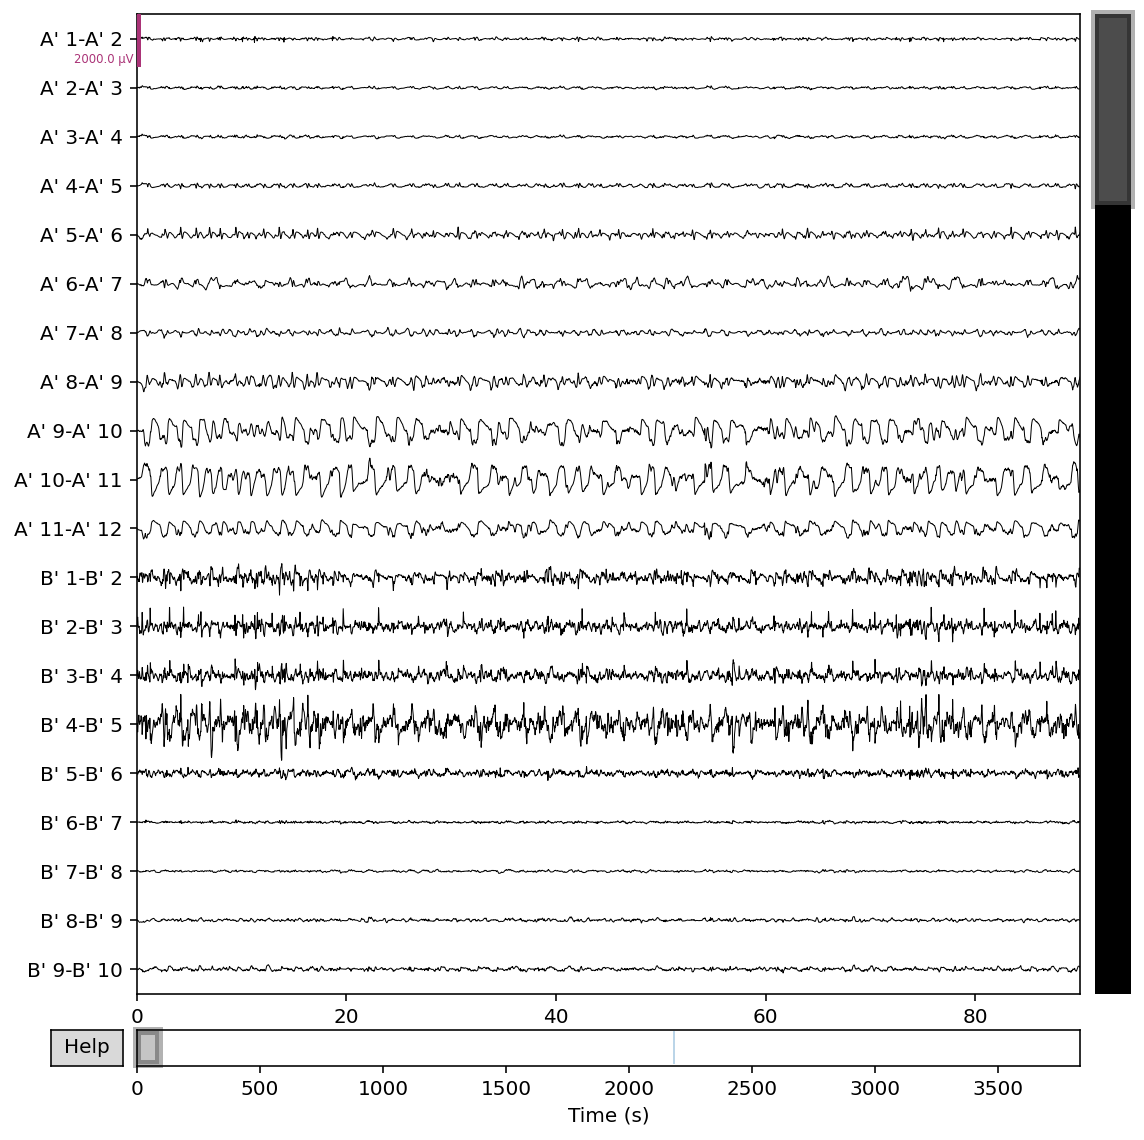

In [10]:
raw.filter(0.5, 15)
raw.plot(scalings={'eeg':1e-3}, duration=90);

In [11]:
len(raw.pick_types(eeg=True).ch_names)

103

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 213 samples (1.664 sec)



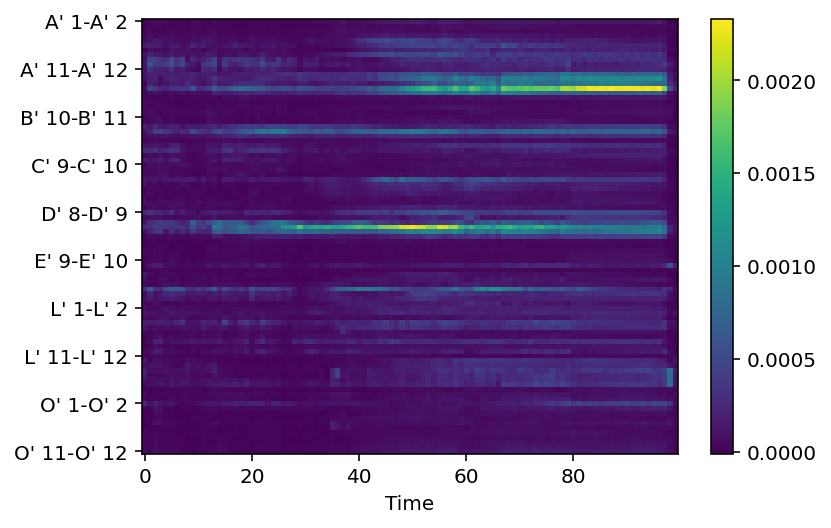

In [12]:
seeg_env = raw.copy().crop(2170,2270)
seeg_env.pick_channels(pick_names)
seeg_env.apply_hilbert(envelope=True)
seeg_env.filter(None,0.1)
seeg_env.resample(1.0)
slp, _ = seeg_env[:]
# slp = np.log(np.clip(slp, 5e-4, slp.max()))
# slp = np.exp(slp)
imshow(slp,aspect='auto'), xlabel('Time'); colorbar()
plt.yticks(np.r_[:len(pick_names)][::10], pick_names[::10]);

In [19]:
pgain = np.abs(bip_gain)

SC = conn.weights.copy()
np.fill_diagonal(SC, np.diag(SC) - SC.sum(axis=1))

stan_data = {
    'nn': SC.shape[0],
    'nt': slp.shape[1],
    'ns': slp.shape[0],
    
    'dt': 0.1,
    'tau0': 10.0,
    'I1': 3.1,
    'Ks': 0.0,
    
    'Obs_seeg': slp.T,
    'SC': SC,
    'Gr': bip_gain,
    'eigen_vec': np.linalg.eig(np.dot(bip_gain.T, bip_gain))[1].real,
    
    'amplitude_fixed': 1,
    'offset_tol': 1.0,
    'offset_offset': 0.0,
    'eps_tol': 1.0,
    'eta_spread': 15.0,
    'eta_offset': -2.5,
    
    'ode_atol': 1e-1,
    'ode_rtol': 1e-1,
    'ode_maxstep': 100_000,
    'ode_solve_order': 40,
    
}
assert stan_data['eigen_vec'].shape[0]==SC.shape[0]
assert bip_gain.shape[0] == slp.shape[0]
%cd /work
cmdstanpy.write_stan_json('data.json', stan_data)
# model = cmdstanpy.CmdStanModel(stan_file='bvep.stan')
fit = model.sample(data=stan_data, inits=0.2, show_console=True, chains=1, save_warmup=1, iter_warmup=500, iter_sampling=200, max_treedepth=13)

/work


RuntimeError: Error during sampling:
Command and output files:
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/work/bvep_', 'id=1', 'random', 'seed=12341', 'data', 'file=/tmp/tmpmjw_f9rc/whm4i4jw.json', 'init=0.2', 'output', 'file=/tmp/tmpmjw_f9rc/bvep_-20220127161029.csv', 'method=sample', 'num_samples=200', 'num_warmup=500', 'save_warmup=1', 'algorithm=hmc', 'engine=nuts', 'max_depth=13', 'adapt', 'engaged=1']
 retcodes=[-1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpmjw_f9rc/bvep_-20220127161029.csv
 console_msgs (if any):
	/tmp/tmpmjw_f9rc/bvep_-20220127161029_0-stdout.txt

In [67]:
summ = fit.summary()

In [74]:
summ

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,6.900000e+04,2.400000e+00,7.900000e+00,69000.000000,69000.00,69000.00,11.000000,0.001400,1.200000
x_init_star[1],-3.800000e-01,9.500000e-03,1.700000e-02,-0.400000,-0.39,-0.35,3.300000,0.000410,2.200000
x_init_star[2],4.600000e-01,3.500000e-03,7.700000e-03,0.450000,0.46,0.47,4.900000,0.000610,1.600000
x_init_star[3],-9.500000e-01,1.800000e-02,3.200000e-02,-0.990000,-0.95,-0.89,3.100000,0.000380,2.400000
x_init_star[4],-2.000000e+00,1.200000e-02,3.500000e-02,-2.000000,-2.00,-1.90,7.700000,0.000950,1.200000
...,...,...,...,...,...,...,...,...,...
log_lik_sum[99],-3.330055e+167,inf,inf,0.000000,0.00,0.00,100.000000,0.012000,NaN
log_lik_sum[100],-2.903150e+209,inf,inf,0.000000,0.00,0.00,100.000000,0.012000,NaN
gx,1.096563e+04,1.031037e+04,1.473837e+05,0.000000,0.00,0.00,204.338683,0.025242,1.000538


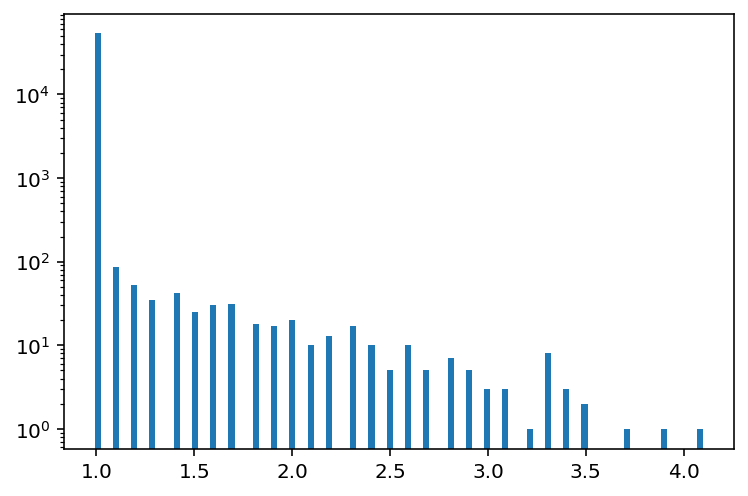

In [73]:
hist(np.array(summ['R_hat']), 100, log=True);

In [60]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,69000.000,27.000,48.000,69000.00,69000.000,69000.000,3.1,0.0030,2.3
x_init_star[1],-0.280,0.028,0.062,-0.37,-0.280,-0.180,4.7,0.0045,1.0
x_init_star[2],-0.052,0.013,0.030,-0.12,-0.043,-0.011,5.4,0.0051,1.0
x_init_star[3],0.390,0.029,0.057,0.29,0.410,0.460,3.8,0.0036,1.7
x_init_star[4],-0.120,0.012,0.022,-0.16,-0.120,-0.096,3.3,0.0032,2.5
...,...,...,...,...,...,...,...,...,...
log_lik_sum[99],540.000,2.700,6.500,528.00,541.000,550.000,5.8,0.0055,1.4
log_lik_sum[100],527.000,5.000,10.000,507.00,530.000,540.000,4.3,0.0041,1.6
gx,3.600,4.600,8.100,-6.10,2.100,16.400,3.1,0.0000,2.2


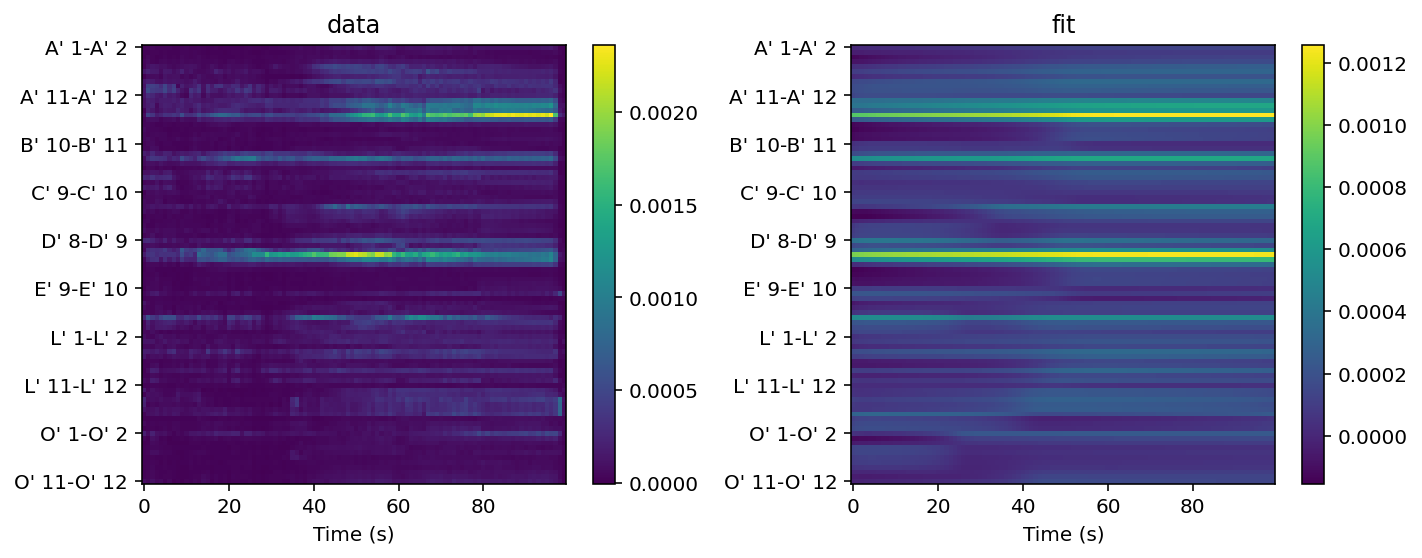

In [375]:
vars = fit.stan_variables()
figure(figsize=(10,4))
subplot(122); imshow(vars['Seeg_qqc'].T,aspect='auto'),  title('fit')
plt.yticks(np.r_[:len(pick_names)][::10], pick_names[::10]), xlabel('Time (s)');colorbar();
subplot(121); imshow(slp,aspect='auto'), title('data'), 
plt.yticks(np.r_[:len(pick_names)][::10], pick_names[::10]), xlabel('Time (s)');colorbar();
tight_layout()

In [376]:
vars['eps']

0.000130341

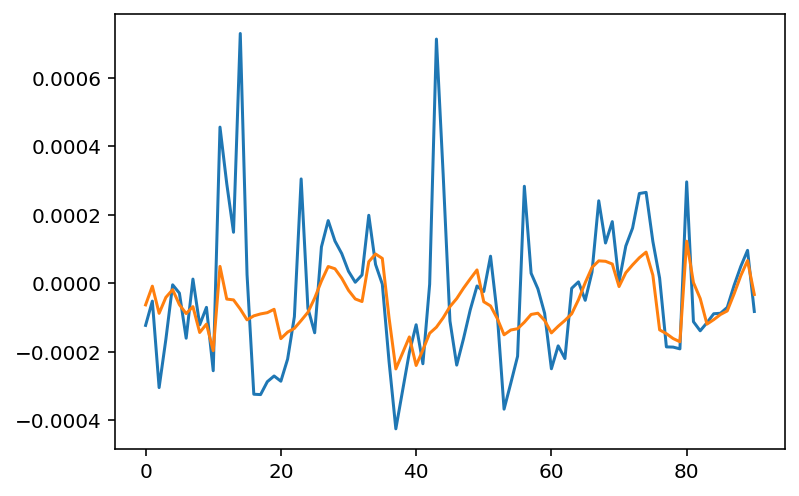

In [377]:
plot(vars['offset'])
plot(bip_gain.sum(axis=1))

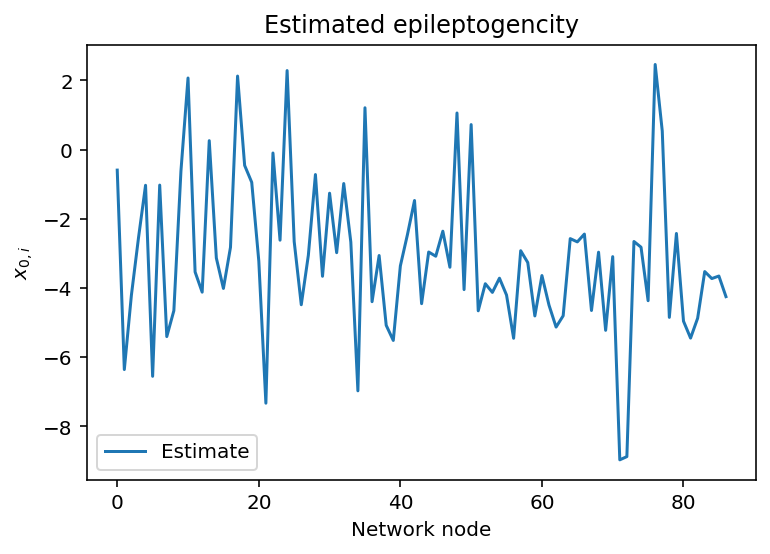

In [378]:
plot(vars['eta']),  legend(('Estimate', 'True'))
xlabel('Network node'), ylabel('$x_{0,i}$'), title('Estimated epileptogencity');

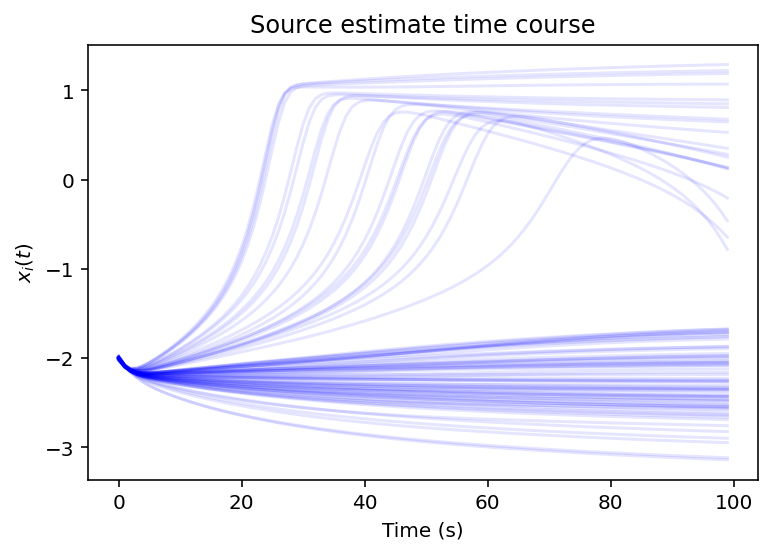

In [379]:
plot(vars['x'].T, 'b', alpha=0.1);
ylabel('$x_i(t)$'), xlabel('Time (s)'), title('Source estimate time course');